In [1]:
%matplotlib inline
DEFAULT_FIGSIZE = (16, 12)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

colors = sns.color_palette('Paired', 10)

In [2]:
import IPython.display

def display_animation(animation):
    plt.close(animation._fig)
    return IPython.display.HTML(animation.to_jshtml())

In [2]:
bicycle_record_files = [
    '2018-04-23_12-30-38.csv',
    '2018-04-23_13-13-36.csv',
    '2018-04-23_14-22-58.csv',
    '2018-04-23_15-27-48.csv',
    '2018-04-23_16-32-27.csv',
    '2018-04-23_17-14-00.csv',
    '2018-04-25_09-27-24.csv',
    '2018-04-25_10-20-28.csv',
    '2018-04-25_11-34-04.csv',
    '2018-04-25_12-41-48.csv',
    '2018-04-25_14-14-57.csv',
    '2018-04-25_14-49-39.csv',
    '2018-04-25_16-15-57.csv',
    '2018-04-25_17-23-04.csv',
    '2018-04-26_11-19-31.csv',
    '2018-04-26_14-50-53.csv',
    '2018-04-27_14-59-52.csv'
]

lidar_record_files = [
    '2018-04-23-12-17-37_0.pkl.gz',
    '2018-04-23-13-01-00_0.pkl.gz',
    '2018-04-23-14-10-33_0.pkl.gz',
    '2018-04-23-15-15-14_0.pkl.gz',
    '2018-04-23-16-19-35_0.pkl.gz',
    '2018-04-23-17-01-24_0.pkl.gz',
    '2018-04-25-09-15-00_0.pkl.gz',
    '2018-04-25-10-07-31_0.pkl.gz',
    '2018-04-25-11-21-29_0.pkl.gz',
    '2018-04-25-12-29-06_0.pkl.gz',
    '2018-04-25-14-02-15_0.pkl.gz',
    '2018-04-25-14-36-55_0.pkl.gz',
    '2018-04-25-16-03-24_0.pkl.gz',
    '2018-04-25-17-10-07_0.pkl.gz',
    '2018-04-26-11-07-38_0.pkl.gz',
    '2018-04-26-14-38-03_0.pkl.gz',
    '2018-04-27-14-47-07_0.pkl.gz',
    '2018-04-27-15-39-56_0.pkl.gz'
]

i = 8 # rider
f1 = bicycle_record_files[i]
f2 = lidar_record_files[i]

with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

data_dir = '../../data/comfort/'
bicycle_rec = load_file(
    os.path.join(data_dir, f1),
    bicycle_calibration['convbike'])
lidar_rec = load_converted_record(
    os.path.join(data_dir, f2))

r = Record(lidar_rec, bicycle_rec)
r.sync()

-5.4800000000000182

<IPython.core.display.Javascript object>


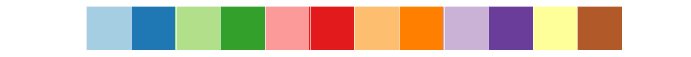

In [6]:
sns.palplot(sns.color_palette('Paired', 12))

In [24]:
1/np.diff(r.lidar.time).mean()

19.999836212938582

In [52]:
#r._calculate_trials2(lidar_bbmask={'xlim': (3.8, 4.4), 'ylim': (2.9, 3.4)})
#r._calculate_trials2(trial_mask=0)
#r._calculate_trials2(missing_sync=[680])

DEFAULT_FIGSIZE = (12, 8)
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
%matplotlib notebook

plt.close('all')
colors = sns.color_palette('Paired', 12)

try:
    #raise AssertionError
    r._calculate_trials2(trial_mask=[9, 10])
except AssertionError:
    # unable to detect events for a trial
    from antlia import trial2
    from antlia.trial2 import Trial2
    from antlia import util
    
    valid_index = Trial2.detect_valid_index(r.lidar)
    event_clumps = np.ma.extras._ezclump(valid_index)
    event_clumps = [c for c in event_clumps if c.stop - c.start > int(5.5*20)]
    
    assert len(event_clumps) > 0
    event_index = event_clumps[-1]
    
    fig, ax = plt.subplots(3, 1, sharex=True)
    # plot sync signal
    ax[0].plot(r.bicycle.time, r.bicycle.sync, color=colors[2]) 
    ax[0].plot(r.lidar.time, r.lidar.sync, color=colors[3]) 
    ax[1].plot(r.lidar.time, r.lidar.sync, color=colors[3]) 
    ax[2].plot(r.lidar.time, r.lidar.sync, color=colors[3]) 
    
    ax[0].plot(r.bicycle.time, r.bicycle.speed, color=colors[0])
    ax[1].plot(r.bicycle.time, r.bicycle.speed > 0.5, color=colors[0])
    #ax[2].plot(r.bicycle.time, mask_b, color=colors[1])
    for c in event_clumps:
        t0 = r.lidar.time[c.start]
        t1 = r.lidar.time[c.stop - 1]
        ax[0].axvspan(t0, t1, color=colors[5], alpha=0.3)
        ax[1].axvspan(t0, t1, color=colors[5], alpha=0.3)
        ax[2].axvspan(t0, t1, color=colors[5], alpha=0.3)
    
    # draw entry/exit bounding box masks
    mask_c = r.lidar.cartesian(**trial2.ENTRY_BB)[0].count(axis=1) > 1
    mask_d0 = r.lidar.cartesian(**EXIT_BB_BRAKE)[0].count(axis=1) > 1
    mask_d1 = r.lidar.cartesian(**EXIT_BB_STEER)[0].count(axis=1) > 1
    ax[2].plot(r.lidar.time, mask_c, color=colors[6])
    ax[2].plot(r.lidar.time, mask_d0, color=colors[8])
    ax[2].plot(r.lidar.time, mask_d1, color=colors[10])
    
    plt.show()

../antlia/trial2.py:1146: UserWarning: Unable to detect cyclist exit or braking for event ending at t = 1351.011 seconds
  except IndexError:


<IPython.core.display.Javascript object>


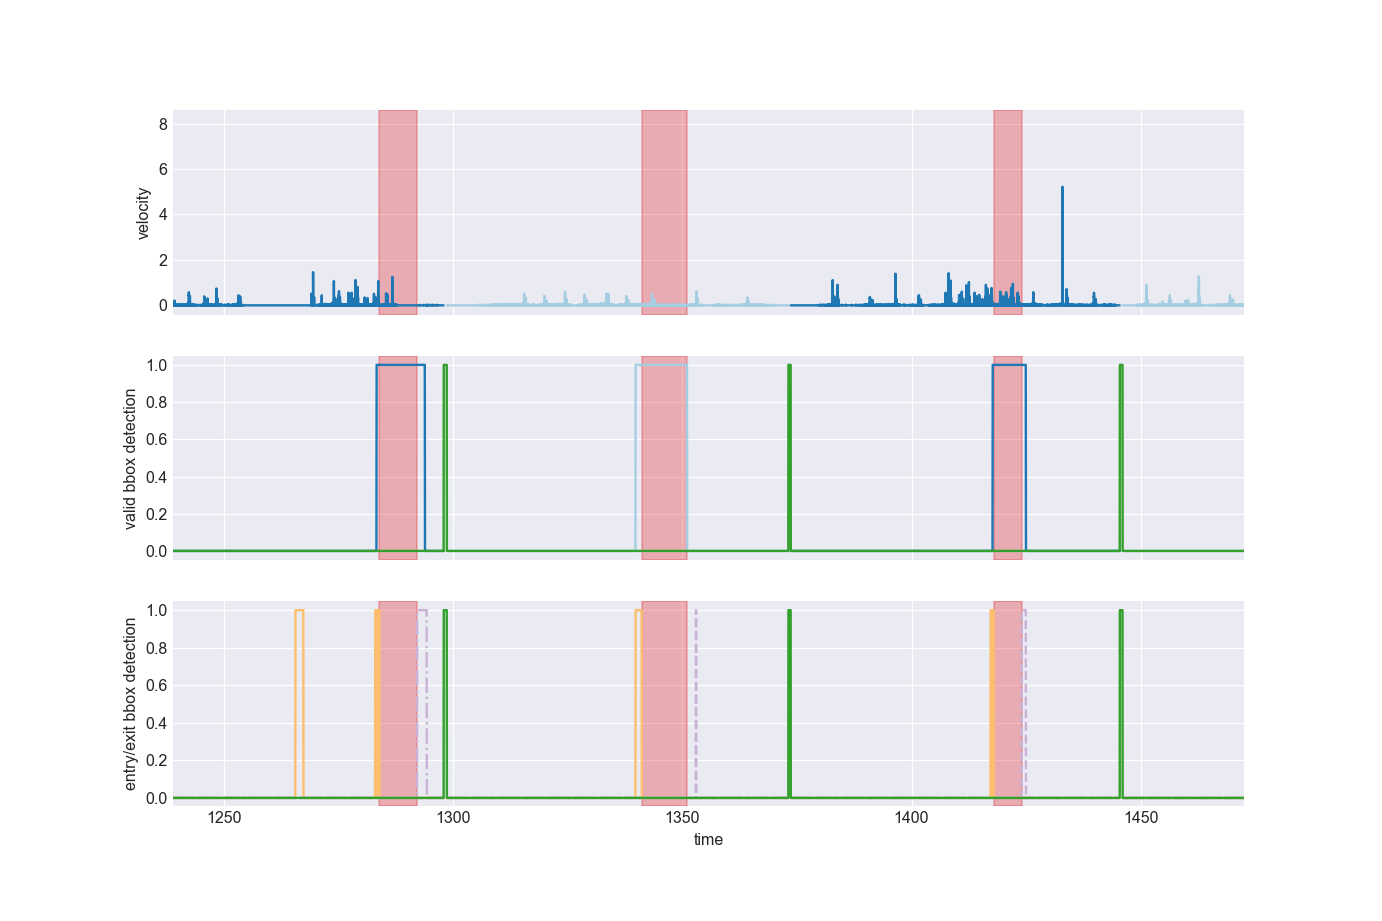

(<Figure size 864x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x13d6b2d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1690f96a0>], dtype=object))

In [48]:
r.plot_trial_detection()

<IPython.core.display.Javascript object>


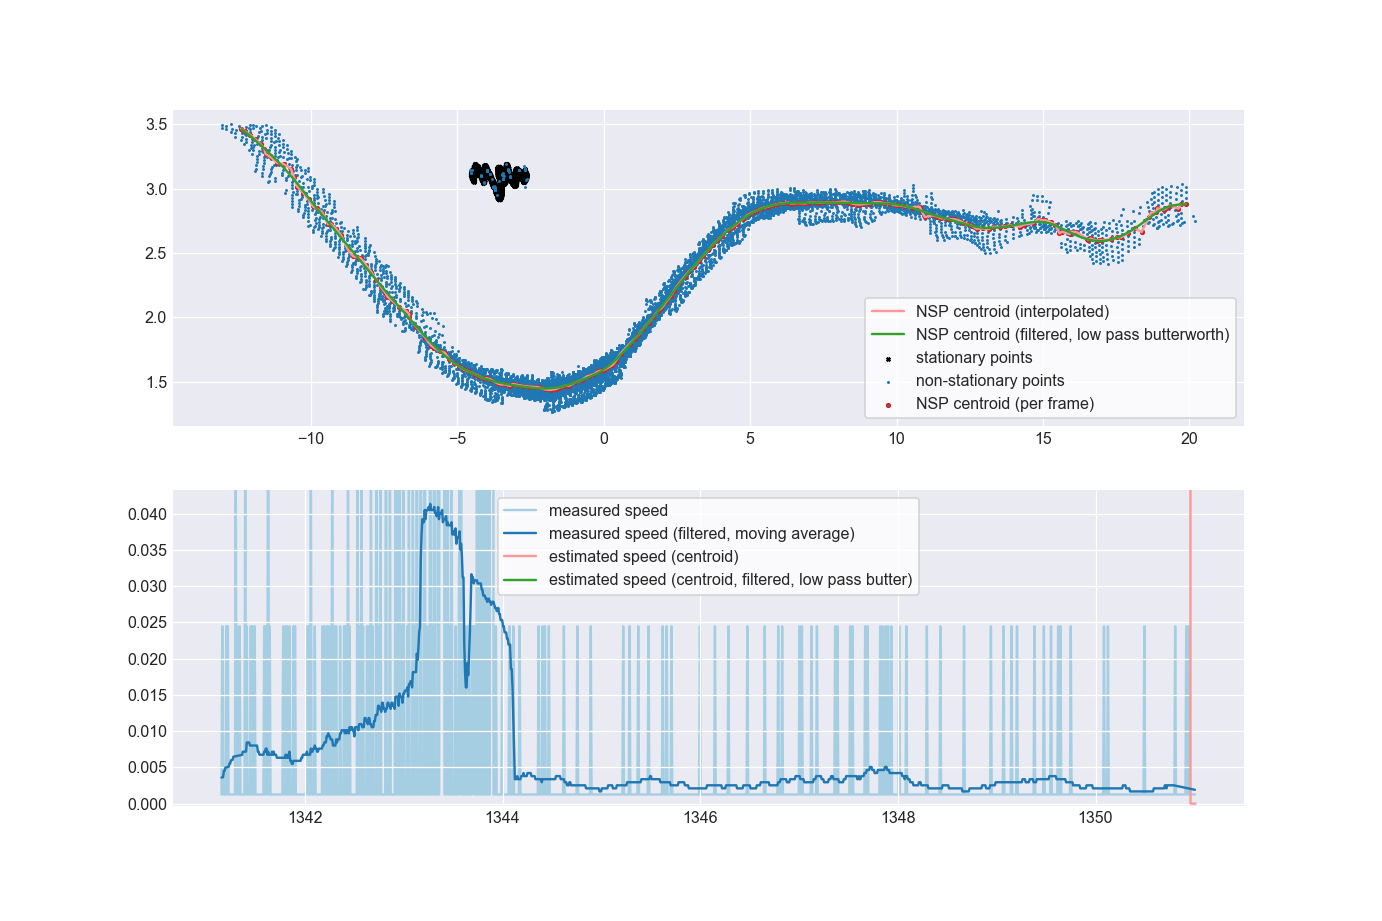

(<Figure size 864x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1692c06d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x16094f240>], dtype=object))

In [49]:
plt.close('all')
r.trials[15].event.plot_trajectory()

<IPython.core.display.Javascript object>


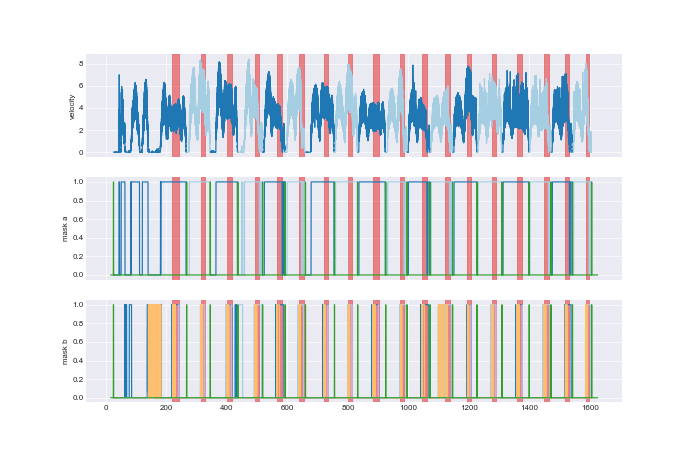

In [15]:
DEFAULT_FIGSIZE = (12, 8)
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
%matplotlib notebook

plt.close()
colors = sns.color_palette('Paired', 12)
#fig, ax = plt.subplots(4, 1, sharex=True)
fig, ax = plt.subplots(3, 1, sharex=True)

i = 0
for t in r.trials:
    i = i ^ 1
    ax[0].plot(t.data.time, t.data.speed, color=colors[i])
    
    ax[1].plot(t.data.time, t.event_detection.mask_a, color=colors[i])
    ax[2].plot(t.data.time, t.event_detection.mask_b, color=colors[i])
    
    t0, t1 = t.event.bicycle.time[[0, -1]]
    ax[0].axvspan(t0, t1, color=colors[5], alpha=0.5)
    ax[1].axvspan(t0, t1, color=colors[5], alpha=0.5)
    ax[2].axvspan(t0, t1, color=colors[5], alpha=0.5)
    
    # cyclist enters from right
    ax[2].plot(t.lidar.time,
               t.lidar.cartesian(xlim=(20, 50), ylim=(2, 3.5))[0].count(axis=1) > 1,
               color=colors[6])
    
    # cyclist exist at left
    ax[2].plot(t.lidar.time,
               t.lidar.cartesian(xlim=(-20, -10), ylim=(2, 3.5))[0].count(axis=1) > 1,
               color=colors[8])
    
    #lidar_subsample = t.lidar[::100]
    #object_count = lidar_object_count(lidar_subsample, xlim=(-10, 30), ylim=(1, 4))
    #ax[3].plot(lidar_subsample.time, object_count > 0, color=colors[i], alpha=0.5)
    #
    #count_interp = np.interp(t.data.time, lidar_subsample.time, object_count)
    #ax[3].plot(t.data.time, count_interp > 0, color=colors[i])
    
ax[1].plot(r.bicycle.time, r.bicycle.sync, color=colors[3]) 
ax[2].plot(r.bicycle.time, r.bicycle.sync, color=colors[3]) 

ax[0].set_ylabel('velocity')
ax[1].set_ylabel('mask a')
ax[2].set_ylabel('mask b')

plt.show()

<IPython.core.display.Javascript object>


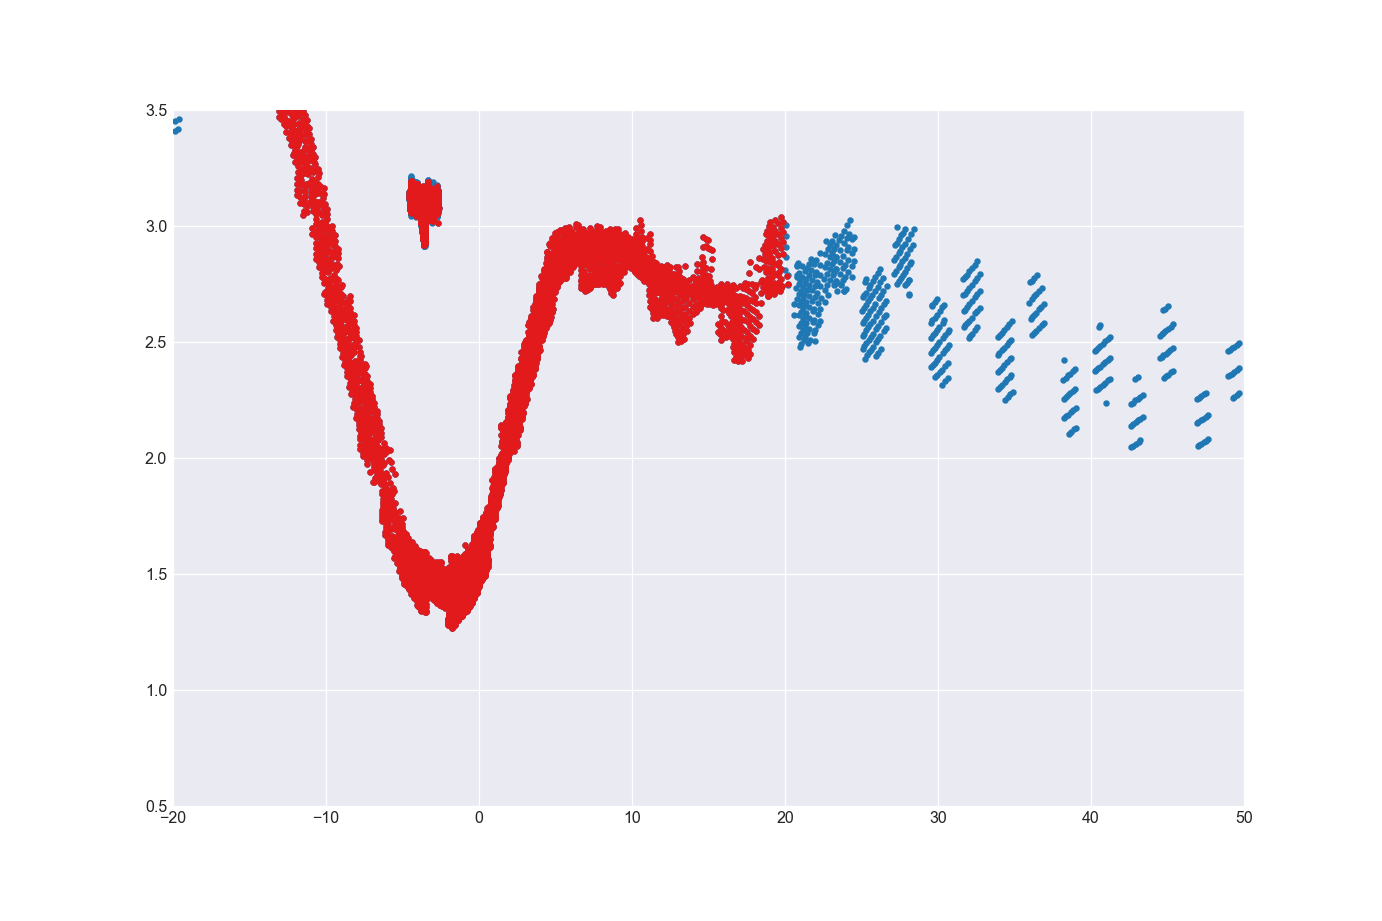

In [50]:
color = sns.color_palette('Paired', 12)[1::2]
plt.close('all')
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
cart_kw = {'xlim': (-20, 50), 'ylim': (0.5, 3.5)}
x, y = [z.compressed() for z in r.trials[15].lidar.cartesian(**cart_kw)]
ax.scatter(x, y, marker='.', color=color[0])

x, y = [z.compressed() for z in r.trials[15].event.lidar.cartesian(**cart_kw)]
ax.scatter(x, y, marker='.', color=color[2])

ax.set_xlim(cart_kw['xlim'])
ax.set_ylim(cart_kw['ylim'])
plt.show()

In [ ]:
DEAFAULT_FIGSIZE = (16, 12)
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
%matplotlib inline

for trial in [r.trials[3]]:
    d = display_animation(trial.event.lidar.animate(
        xlim=(-40, 40),
        ylim=(0, 4),
        rlim=(0, 110),
        figsize=DEFAULT_FIGSIZE))
    IPython.display.display(d)

In [53]:
for i, t in enumerate(r.trials):
    print(i, t.event.type)
    #print(i, dict(t.event_detection._asdict()))
    #print()

0 Braking
1 Braking
2 Braking
3 Overtaking
4 Overtaking
5 Overtaking
6 Braking
7 Braking
8 Braking
9 Overtaking
10 Overtaking
11 Overtaking
12 Braking
13 Braking
14 Braking
15 Overtaking
16 Overtaking
17 Overtaking


(array([ (-1.38573454,  114.74875584, -0.92134532,   1.08839852e-168,  0.02901747,  3.85448161,  3.264409,  6.6237451,  79.710703,  82.975112, 55, [8131, 8540], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.02362814, -0.02416733, -0.02454105, ...,  0.01431309,
        0.01111335,  0.00796344]), [])



<IPython.core.display.Javascript object>


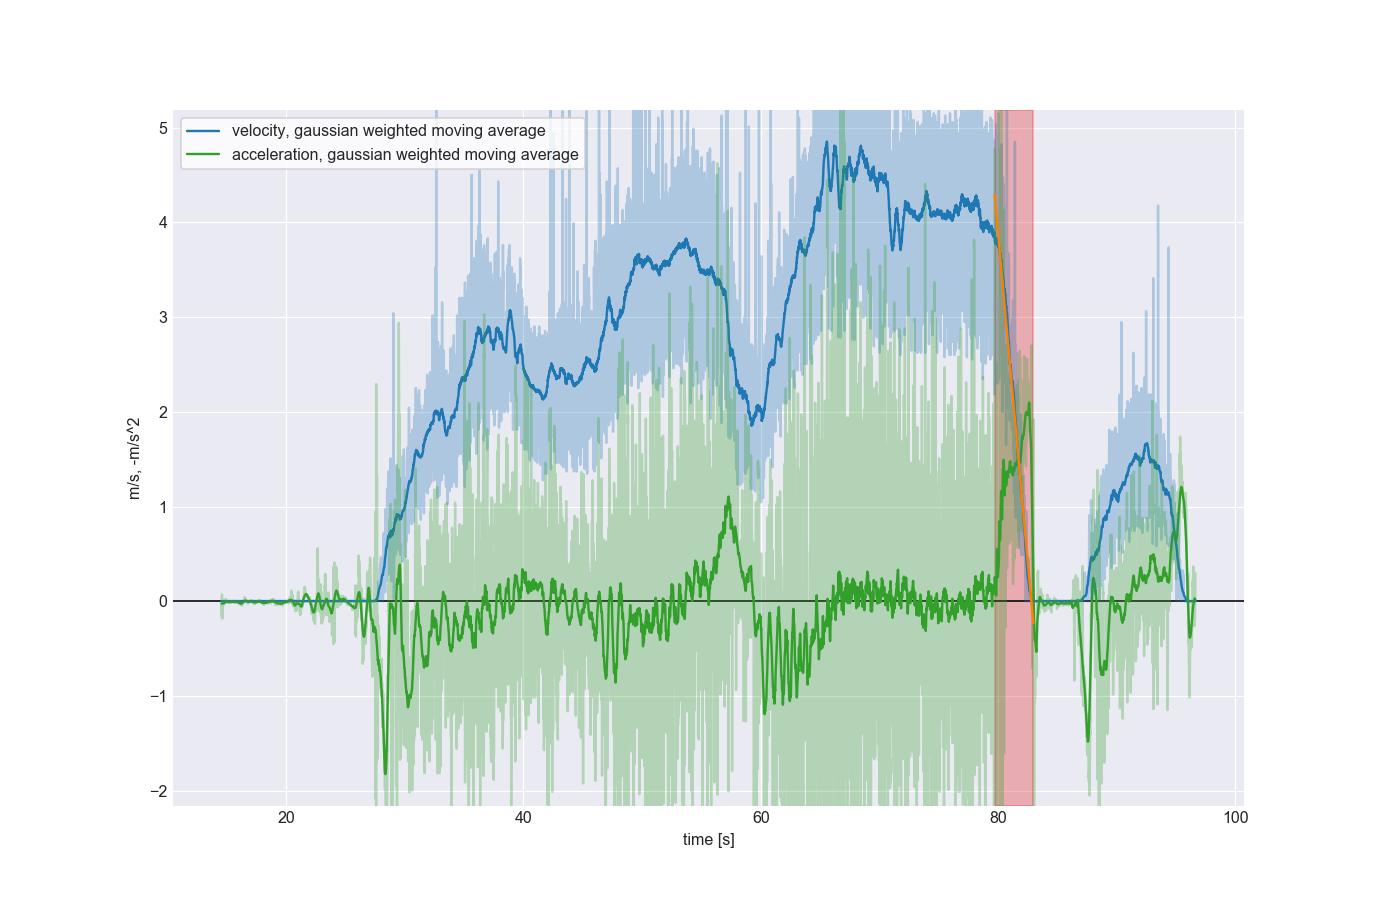

(array([ (-1.24889348,  205.07440244, -0.95565398,   2.41747564e-195,  0.02017192,  3.22879525,  2.928367,  4.65092985,  161.468983,  164.39735, 55, [8006, 8373], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.15027426, -0.15289196, -0.15517419, ...,  0.01232569,
        0.01120419,  0.00959545]), [])



<IPython.core.display.Javascript object>


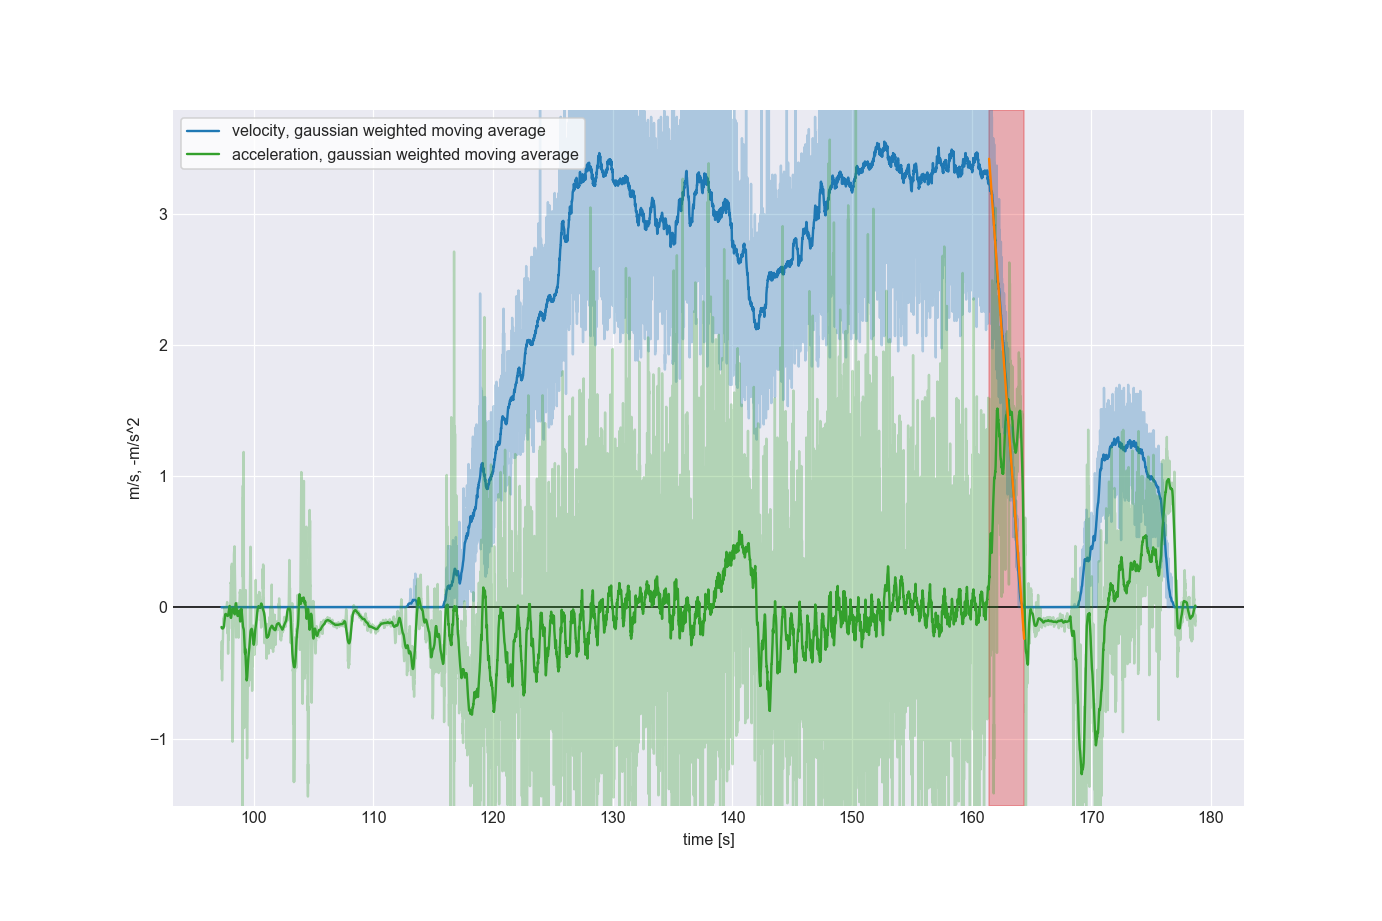

(array([ (-1.73068241,  448.76134772, -0.94999501,   5.73035890e-219,  0.02746571,  5.27913317,  3.448435,  9.16260581,  256.037872,  259.486307, 55, [ 9574, 10006], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.0065791 , -0.00695956, -0.00745905, ...,  0.05044649,
        0.05873905,  0.06607614]), [])



<IPython.core.display.Javascript object>


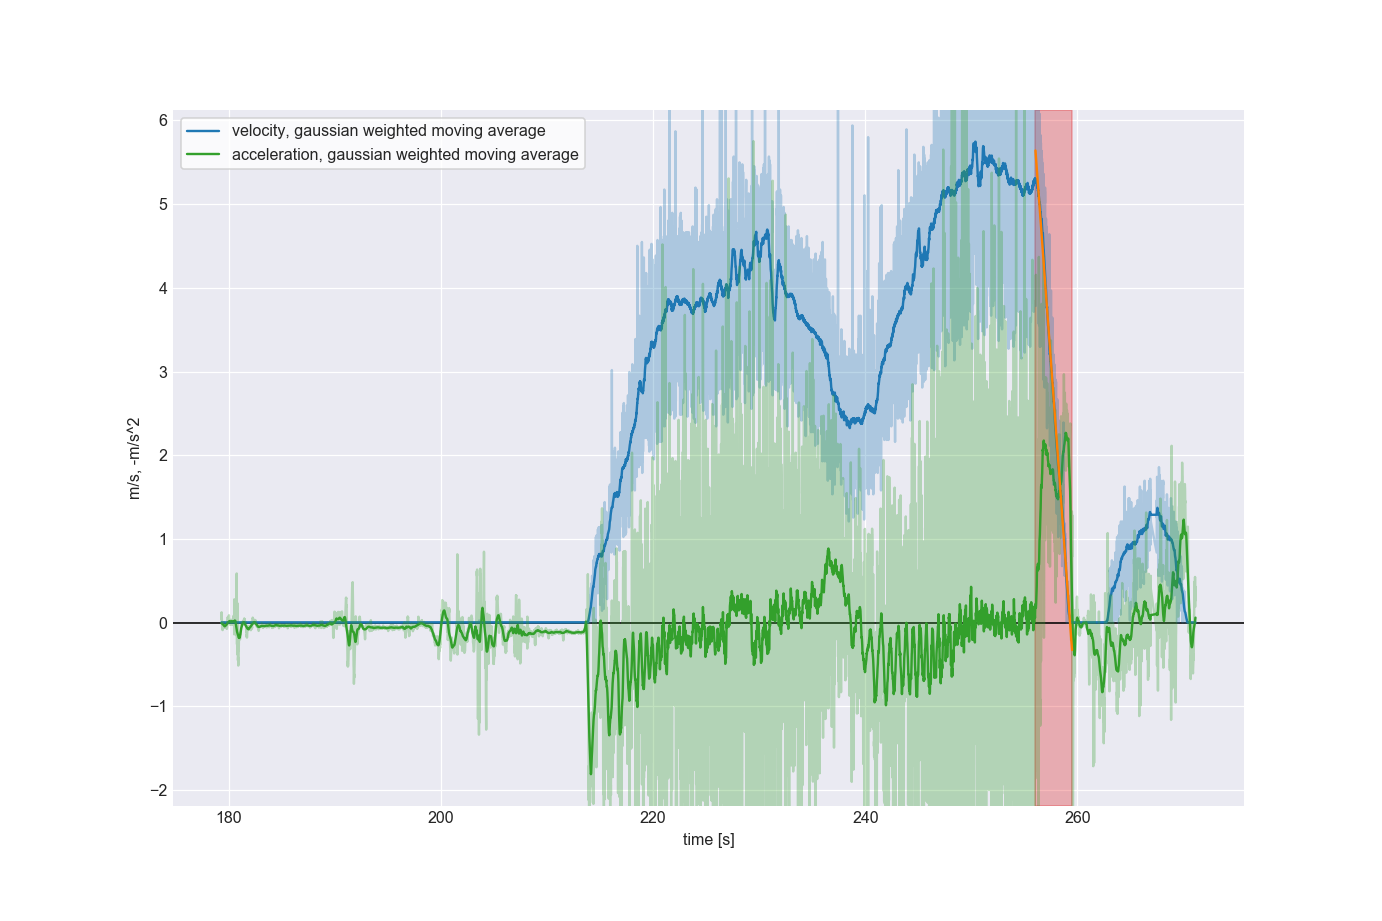

(array([ (-0.00431971,  2.34207545, -0.32778123,   1.06546525e-11,  0.00061715,  0.02183241,  3.320417,  0.01656427,  539.368496,  542.688913, 55, [5731, 6141], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.01932208, -0.02034231, -0.02134533, ..., -0.03939716,
       -0.03708712, -0.0348034 ]), [])



<IPython.core.display.Javascript object>


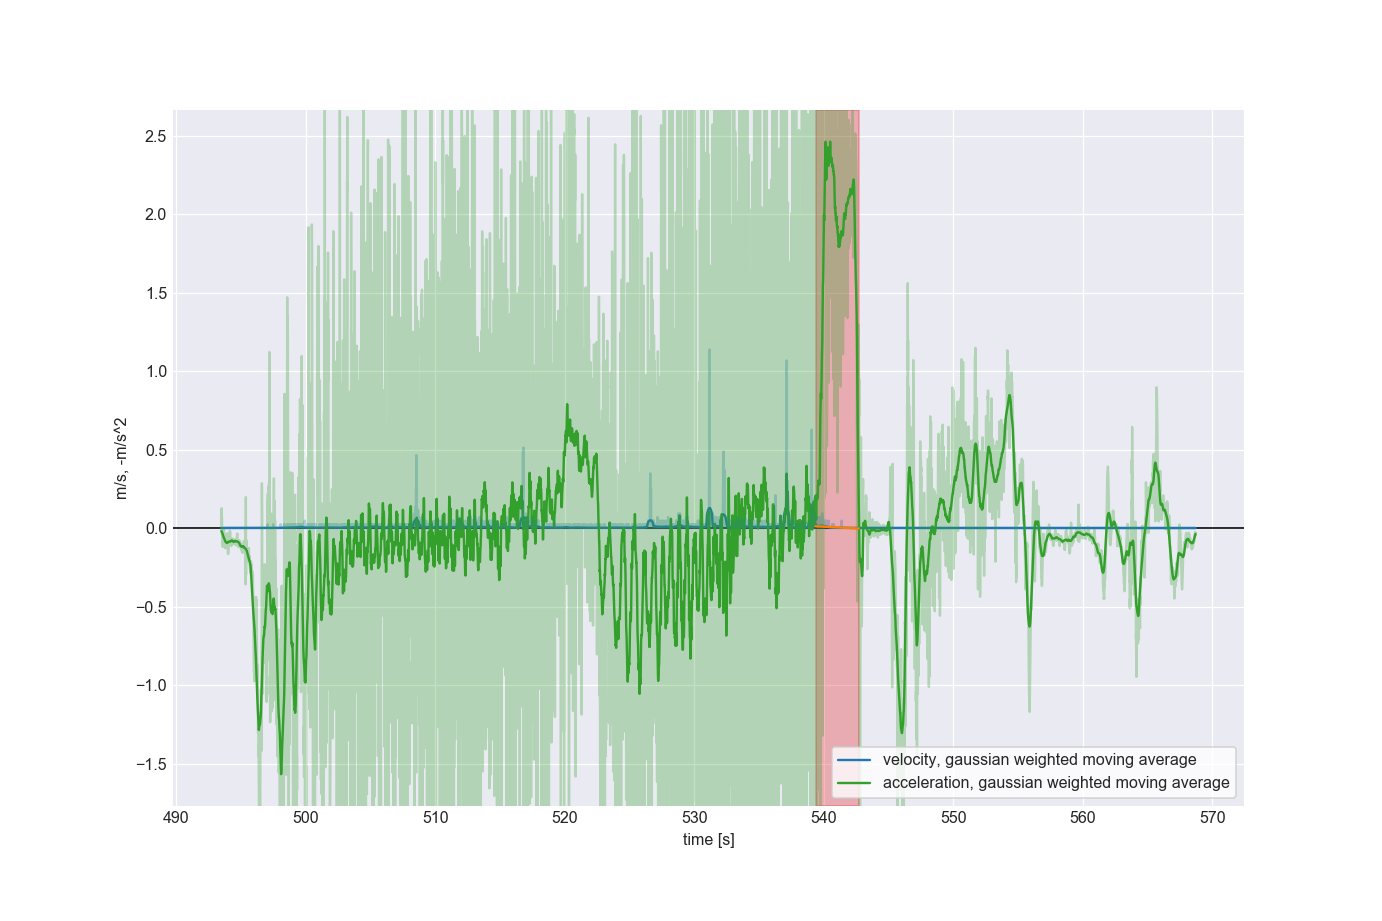

(array([ (-0.0029736,  1.82967929, -0.25587077,   5.49185671e-10,  0.00047098,  0.05402889,  4.632588,  0.02349015,  611.28554,  615.918128, 55, [5212, 5784], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.03100136, -0.03213005, -0.03325478, ...,  0.08954865,
        0.07576082,  0.06268647]), [])



<IPython.core.display.Javascript object>


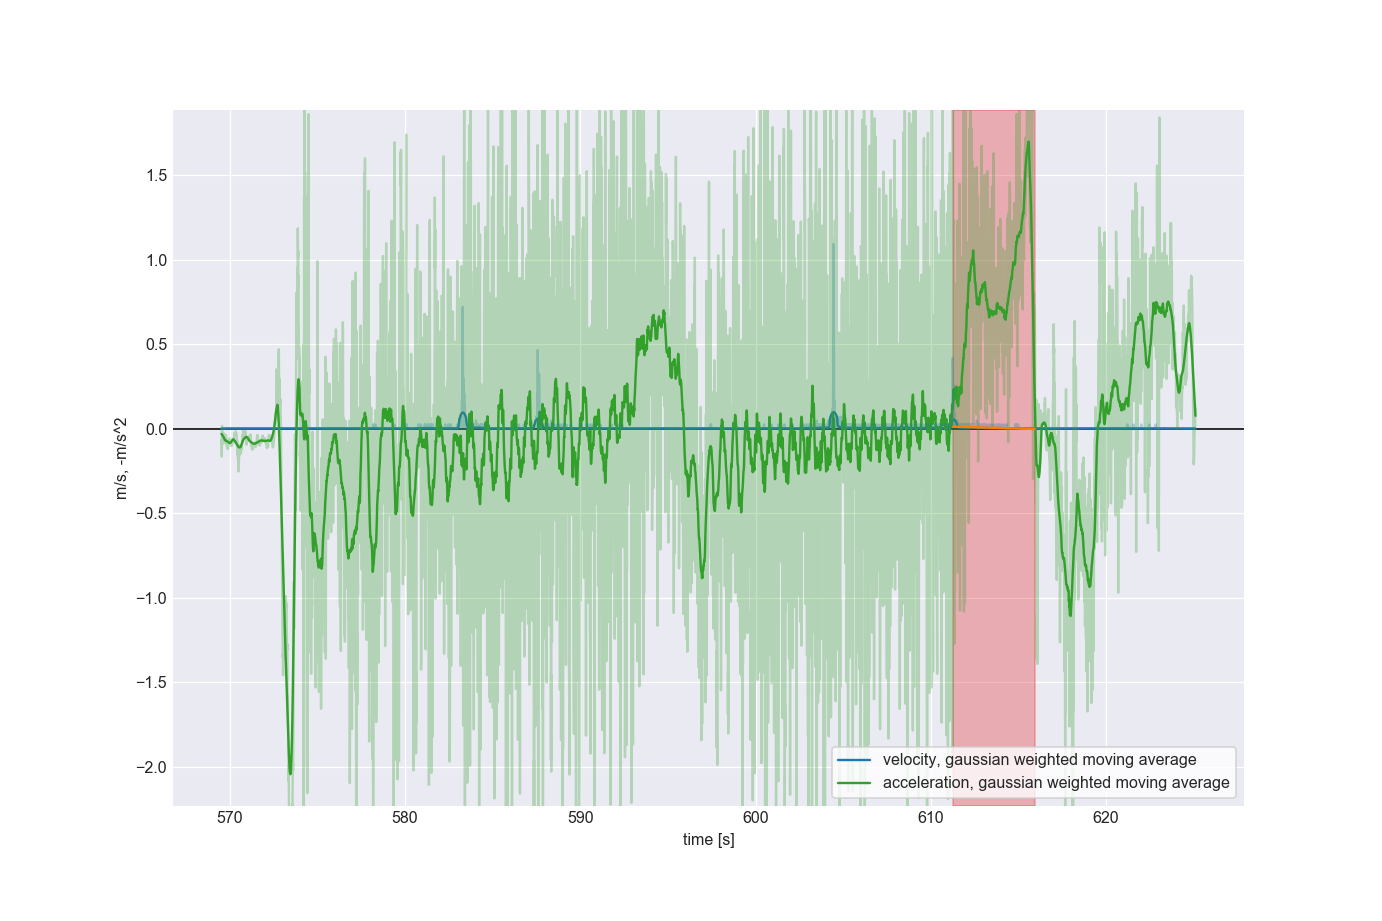

(array([ (-0.0072086,  4.88768515, -0.19990409,   3.53104725e-05,  0.00172405,  0.15215386,  3.396455,  0.01996117,  675.521616,  678.918071, 55, [6223, 6646], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([ 0.00420032,  0.00478389,  0.00543074, ..., -0.09555525,
       -0.08818097, -0.07953828]), [])



<IPython.core.display.Javascript object>


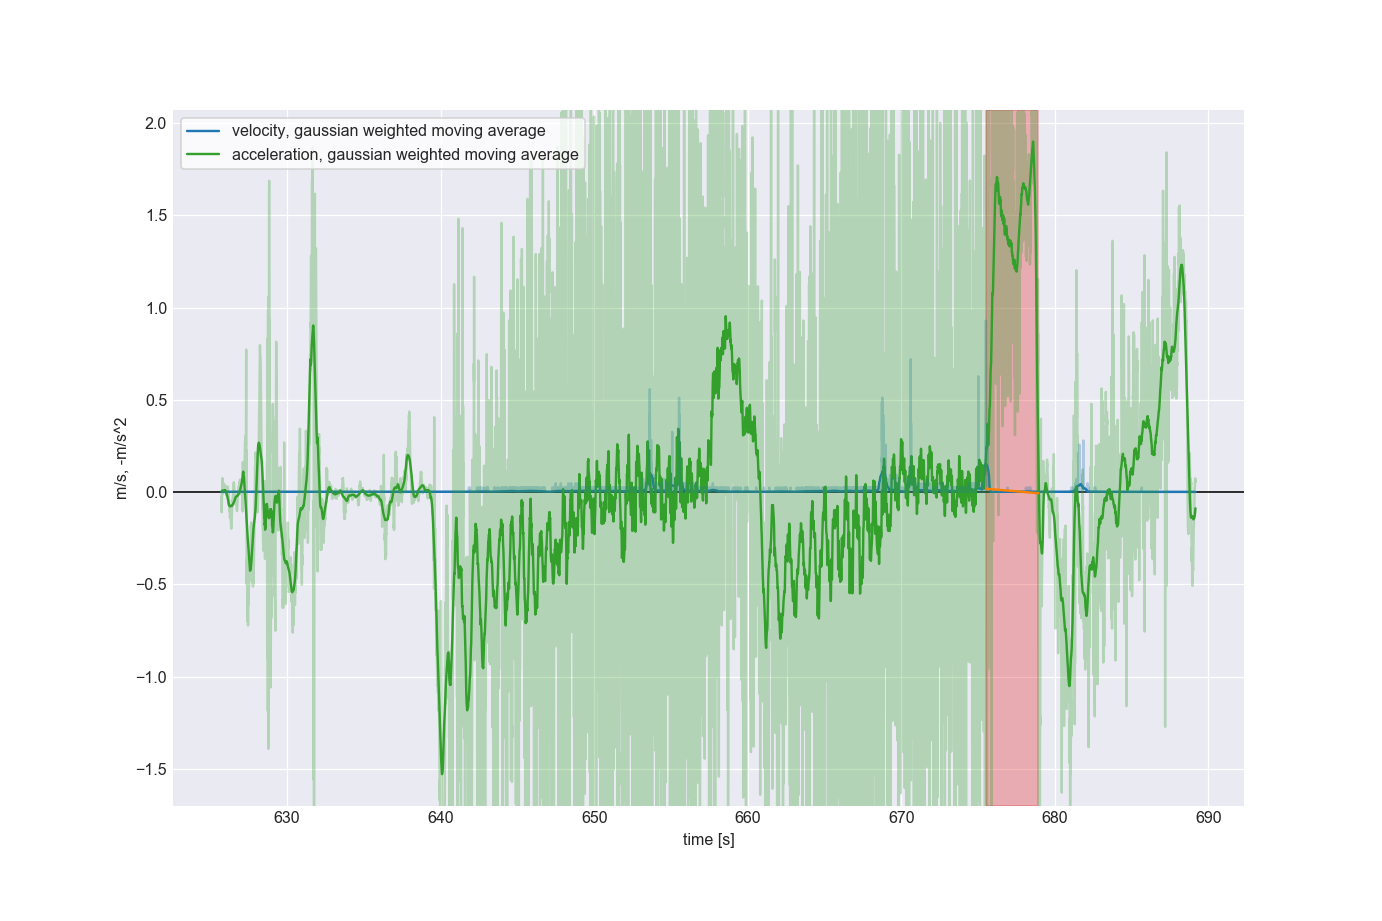

(array([ (-0.000473,  0.54513379, -0.12535977,  0.01949176,  0.00020154,  0.00237306,  2.776348,  0.00460462,  1147.596973,  1150.373321, 55, [5274, 5622], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.02981311, -0.03096146, -0.03201441, ...,  0.10305809,
        0.0932174 ,  0.08412061]), [])



<IPython.core.display.Javascript object>


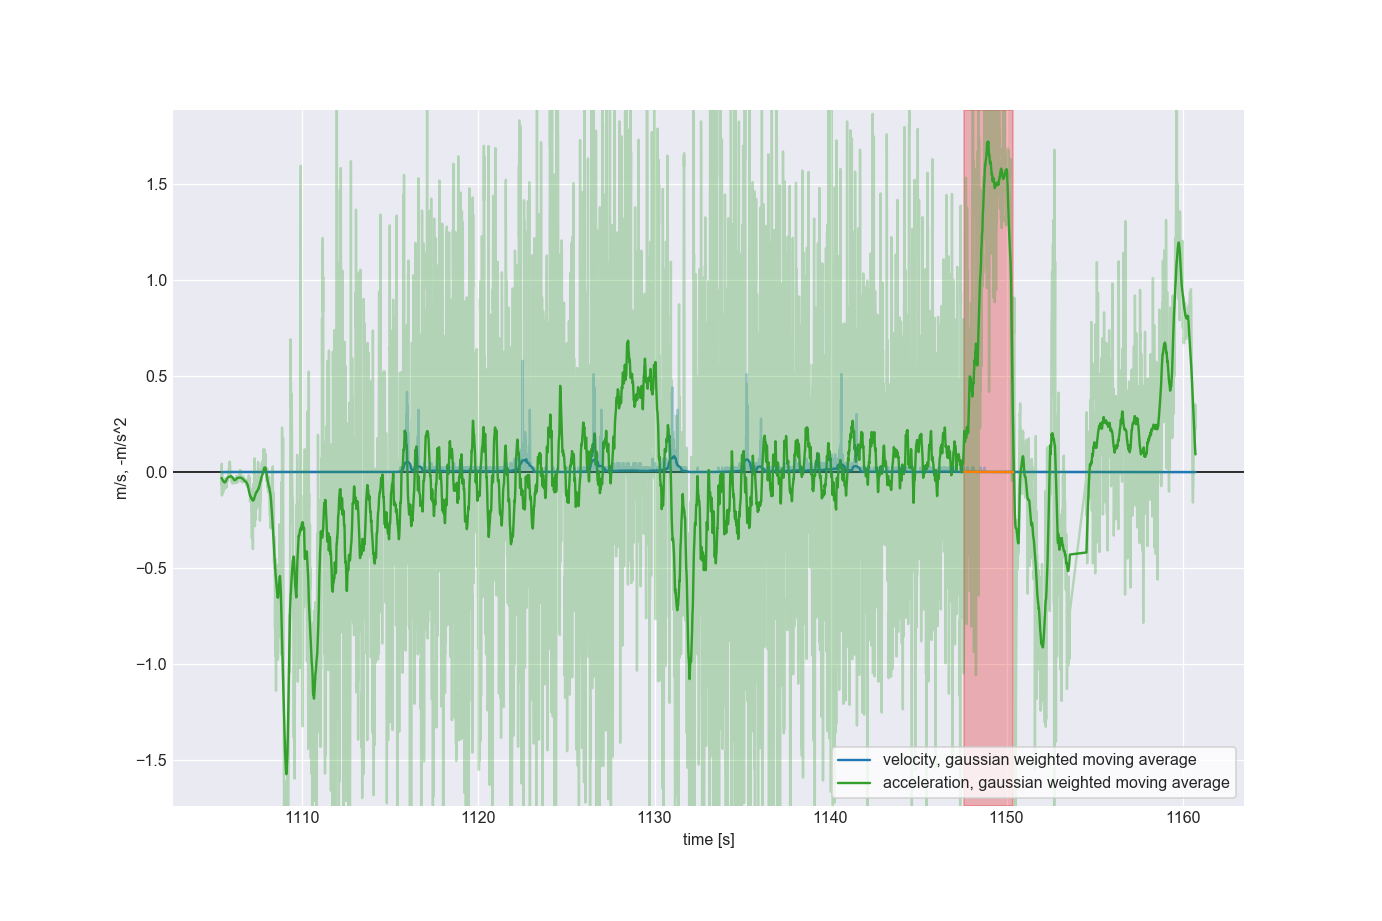

(array([ (-0.00483991,  5.86212202, -0.10346414,  0.04061477,  0.00235602,  0.00642347,  3.136393,  0.01391202,  1208.719659,  1211.856052, 55, [5891, 6284], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.02105475, -0.02503063, -0.02872856, ..., -0.09881445,
       -0.0976532 , -0.09570432]), [])



<IPython.core.display.Javascript object>


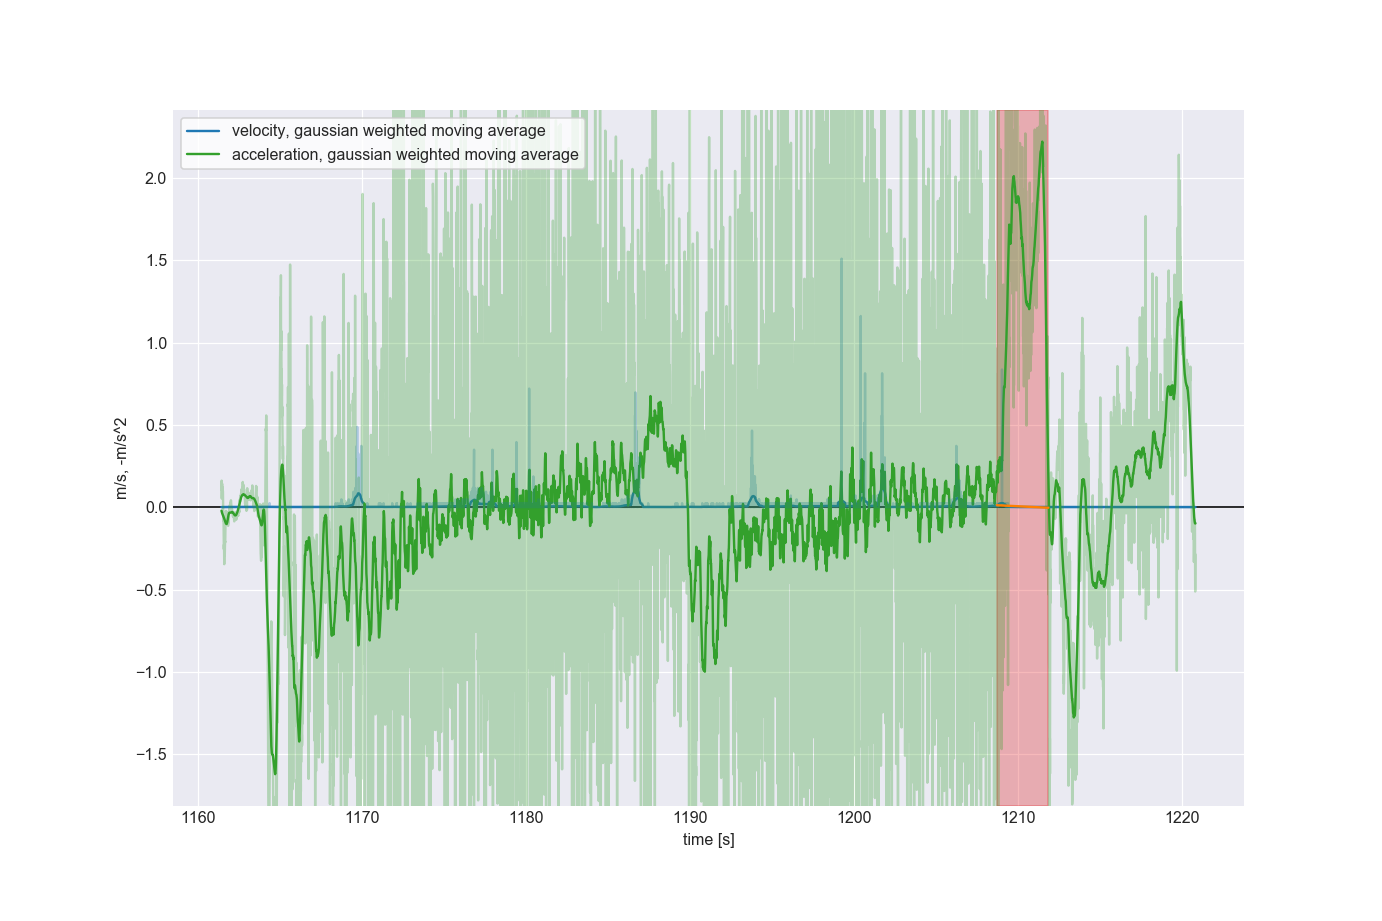

(array([ (-0.0134538,  17.33512137, -0.13283059,  0.03976524,  0.00650718,  0.09267705,  2.800375,  0.05467157,  1285.641326,  1288.441701, 55, [8007, 8358], 3, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.01056267, -0.01179277, -0.01324885, ..., -0.18022676,
       -0.17590182, -0.17072823]), [(8097, 8142), (8146, 8146), (8148, 8213)])



<IPython.core.display.Javascript object>


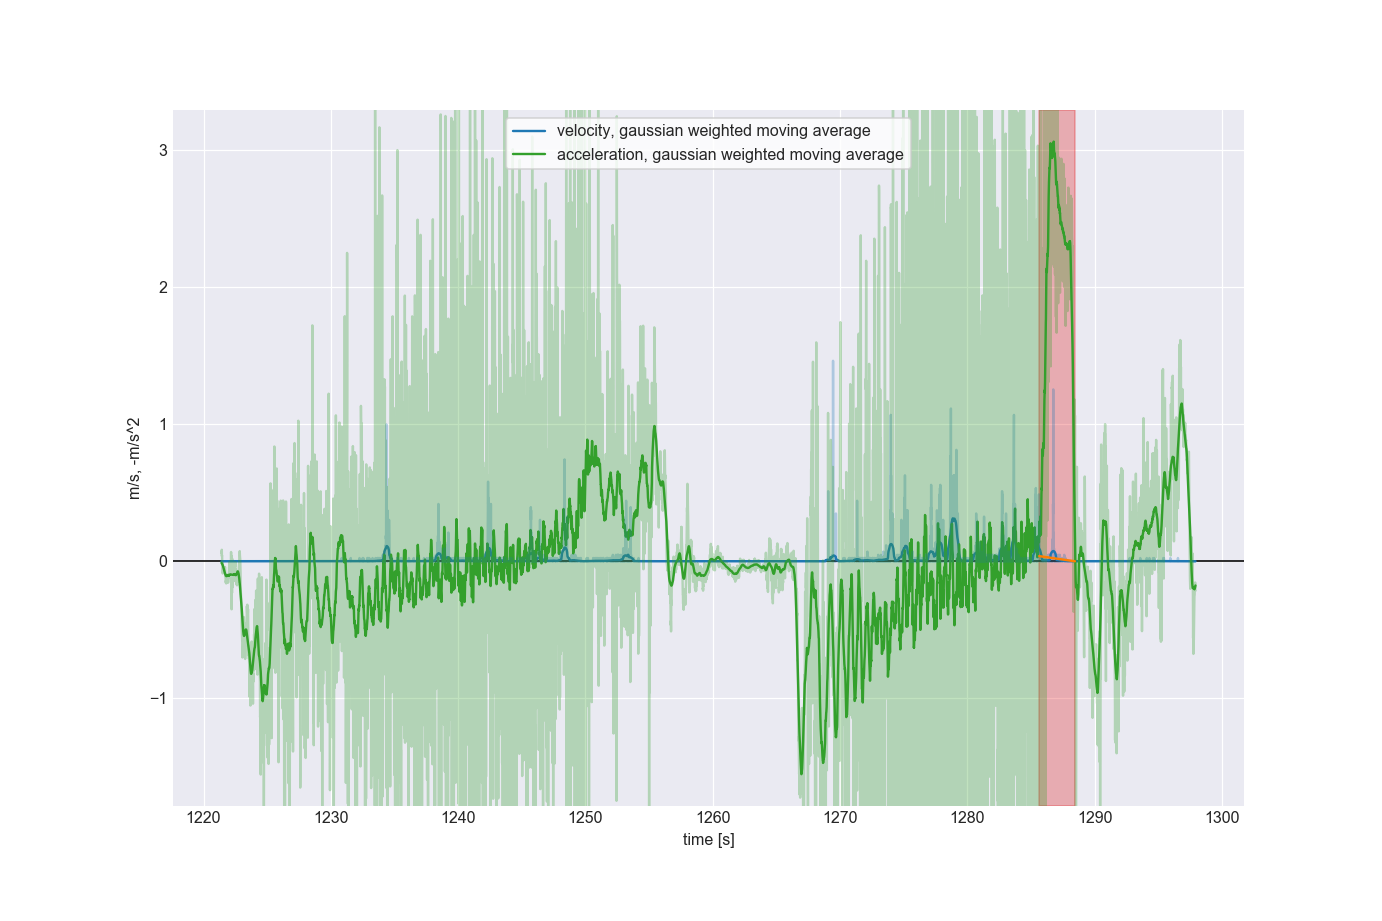

In [58]:
from antlia import plot_braking as braking
from antlia import trial2

plt.close('all')
for trial in r.trials:
    #if trial.event.type != EventType.Braking:
    if trial.event.type.value != trial2.EventType.Braking.value:
        continue
    
    metrics_kw = {'braking_threshold': 0.2, 'min_size': 30}
        
    m = braking.get_metrics(trial.bicycle, **metrics_kw)
    print(m)
    print()
    
    braking.plot_trial_braking_event(
        trial.bicycle, metrics_kw=metrics_kw)
    
plt.show()

In [ ]:
#x, y = r.lidar.frame(250).cartesian(**cart_kw)
x, y = r.lidar.frame(lambda t: (t > 200) & (t < 250)).cartesian(**cart_kw)
print(x)
print(x.shape)
print(y)
print(y.shape)
print()
X = np.vstack((x[0].compressed(), y[0].compressed())).transpose()
#print(X)

np.zeros((3,))

import hdbscan

def lidar_object_count(lidarrec, xlim=None, ylim=None, rlim=None):
    x, y = lidarrec.cartesian(xlim, ylim, rlim)
    
    count = np.zeros((x.shape[0],))
    for i in range(x.shape[0]):
        X = np.vstack((
                x[i].compressed(),
                y[i].compressed())).transpose()
        hdb = hdbscan.HDBSCAN(
                min_cluster_size=10,
                min_samples=10,
                allow_single_cluster=True,
                metric='euclidean').fit(X)
        count[i] = max(hdb.labels_)
    return count

#count = lidar_object_count(r.lidar.frame(lambda t: (t > 200) & (t < 250)), xlim=(-10, 30), ylim=(0, 4))